<a href="https://colab.research.google.com/github/Vaipik/GoIT-PyDS7/blob/main/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=7f7332d2f1a8c8d28a8cb6119eec89b8e42a5ee5857c88798dbe2b45485ed150
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Завдання 1

Створити спарк сесію.

In [3]:
import pyspark
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1" # без этой строчки у нас будет возникать постоянное предупреждение с просьбой установить эту переменную в значение 1, что мы заранее и делаем

spark = pyspark.sql.SparkSession.builder.getOrCreate()

Прочитати датасет в датафрейм.

In [88]:
df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/bestsellers with categories.csv', header=True, inferSchema=True)

df

DataFrame[Name: string, Author: string, User Rating: double, Reviews: int, Price: int, Year: int, Genre: string]

Використовуючи тільки RDD, обчислити середню ціну всіх книг, у яких рейтинг вищий за 4.7

In [64]:
filtered = df.rdd.filter(lambda x: x["User Rating"] > 4.7)

amount = filtered.count()
sum_ = 0
for k in filtered.collect():
  sum_ += k["Price"]

print(f"Average books price: {sum_/amount:.2f}")

MapPartitionsRDD[134] at javaToPython at NativeMethodAccessorImpl.java:0

Побудувати гістограму розподілу рецензій (стовпчик Reviews).

<Axes: ylabel='Frequency'>

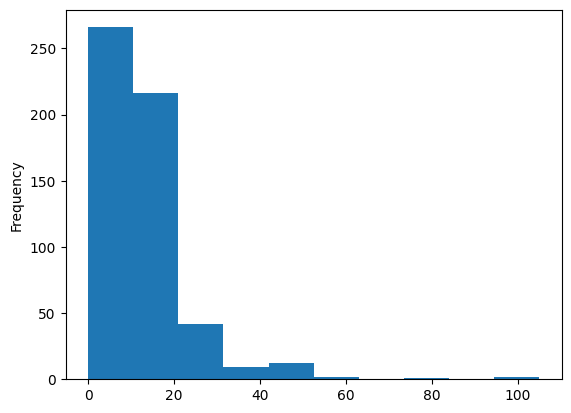

In [67]:
pd_df = df.toPandas()
pd_df.Price.plot(kind="hist")

Побудувати матрицю кореляції для стовпців "User Rating", "Reviews" та "Price".

In [80]:
mtrx = pd_df.corr(numeric_only=True).loc[["User Rating", "Reviews", "Price"], ["User Rating", "Reviews", "Price"]]
mtrx

,User Rating,Reviews,Price
User Rating,1.000000,-0.001729,-0.133086
Reviews,-0.001729,1.000000,-0.109182
Price,-0.133086,-0.109182,1.000000


Використовуючи бібліотеку seaborn, побудувати парні графіки (pairplots) стовпців "User Rating", "Reviews" та "Price".

In [81]:
import seaborn as sns

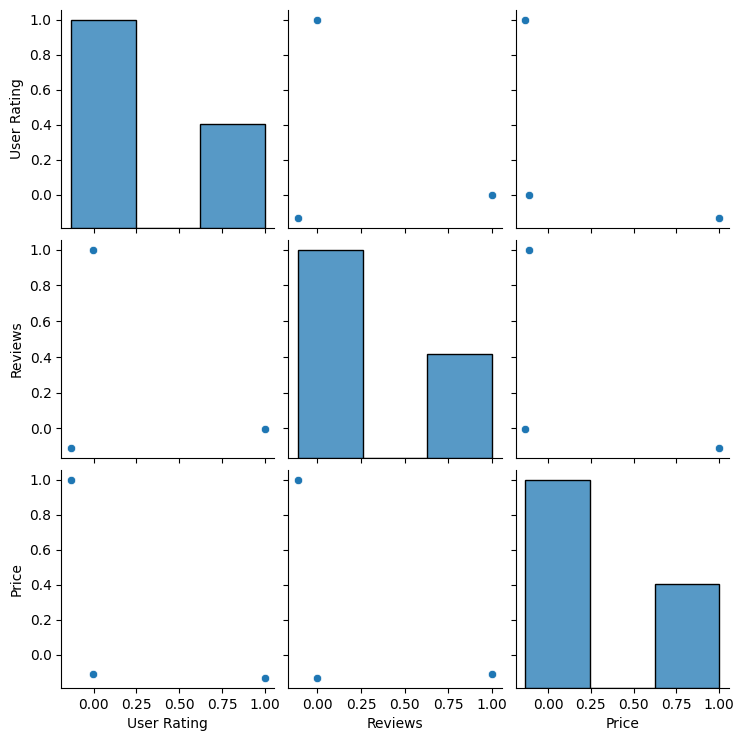

In [87]:
sns.pairplot(mtrx, kind="scatter")

# Завдання 2#

Під час виконання цього завдання дозволяється використовувати лише Spark SQL. Для датасету з попереднього завдання виконайте наступне:

In [101]:
df.show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

Знайдіть автора з найвищим рейтингом.

In [111]:
"""
SELECT Author FROM df
ORDER_BY User Rating DESC
LIMIT 1;

SELECT Author from df
WHERE user rating = SELECT(MAX(User Rating from df))

"""
from pyspark.sql.functions import desc
df.select("Author", "User Rating").orderBy(desc("User Rating")).limit(1).show()

+---------------+-----------+
|         Author|User Rating|
+---------------+-----------+
|Bill Martin Jr.|        4.9|
+---------------+-----------+



Знайдіть трьох авторів із найнижчим рейтингом.

In [147]:
"""
SELECT Author, User Rating FROM df
ORDER_BY User Rating ASC;
LIMIT 3;
"""
from pyspark.sql.functions import asc
df.select("Author", "User Rating").orderBy(asc("User Rating")).limit(3).show()

+------------+-----------+
|      Author|User Rating|
+------------+-----------+
|J.K. Rowling|        3.3|
|  Harper Lee|        3.6|
|   E L James|        3.8|
+------------+-----------+



Визначте, який автор отримав найбільшу кількість рецензій.

In [109]:
"""
SELECT Author, User Rating FROM df
ORDER_BY User Rating DESC;
LIMIT 1;
"""
df.select("Author", "Reviews").orderBy(desc("Reviews")).limit(1).show()

+-----------+-------+
|     Author|Reviews|
+-----------+-------+
|Delia Owens|  87841|
+-----------+-------+



Визначте, який автор написав найбільшу кількість книг за весь доступний у даних період.

In [121]:
"""
SELECT Author, COUNT(Name) as total_books FROM df
GROUP BY Author
ORDER BY total_books DESC
LIMIT 1;
"""
from pyspark.sql.functions import count
df.groupBy("Author").count().limit(1).show()

+-----------+-----+
|     Author|count|
+-----------+-----+
|Sarah Young|    6|
+-----------+-----+



Визначте, яка книга жанру "Fiction" має найменший рейтинг.

In [123]:
"""
SELECT Name, Author, User Rating, Genre FROM df
WHERE GENRE = Fiction
ORDER_BY User Rating ASC
LIMIT 1;
"""
df.select("Name", "Author", "User Rating", "Genre").where(df.Genre == "Fiction").orderBy(asc("User Rating")).limit(1).show()

+------------------+------------+-----------+-------+
|              Name|      Author|User Rating|  Genre|
+------------------+------------+-----------+-------+
|The Casual Vacancy|J.K. Rowling|        3.3|Fiction|
+------------------+------------+-----------+-------+



Визначте, яка книга жанру "Non Fiction" має найвищий рейтинг.

In [124]:
"""
SELECT Name, Author, User Rating, Genre FROM df
WHERE GENRE = Non Fiction
ORDER_BY User Rating DESC
LIMIT 1;
"""
df.select("Name", "Author", "User Rating", "Genre").where(df.Genre == "Non Fiction").orderBy(desc("User Rating")).limit(1).show()

+--------------------+------------------+-----------+-----------+
|                Name|            Author|User Rating|      Genre|
+--------------------+------------------+-----------+-----------+
|Hamilton: The Rev...|Lin-Manuel Miranda|        4.9|Non Fiction|
+--------------------+------------------+-----------+-----------+



# Завдання 3

Побудуйте гістограму середньої кількості рецензій за роками.

+----+------------+
|Year|avg(Reviews)|
+----+------------+
|2018|    13930.42|
|2015|    14233.38|
|2013|    13098.14|
|2014|    15859.94|
|2019|    15898.34|
|2012|    13090.92|
|2009|     4710.12|
|2016|     14196.0|
|2010|     5479.62|
|2011|     8100.82|
|2017|     12888.4|
+----+------------+



<Axes: xlabel='Year', ylabel='avg(Reviews)'>

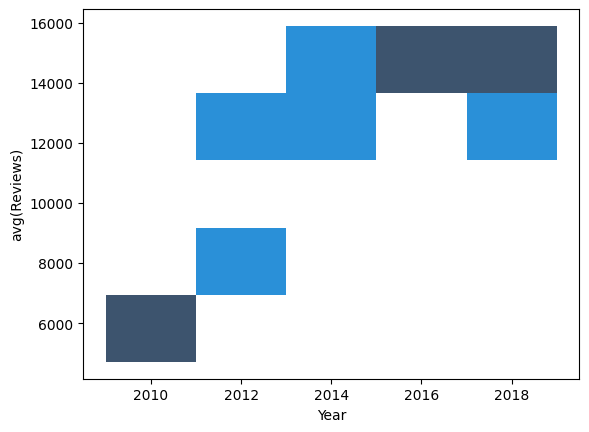

In [160]:
"""
SELECT Year, AVG(Reviews) as Average FROM df
GROUP_BY Year
ORDER BY YEAR;
"""
avg_reviews = df.groupBy("Year").avg("Reviews")
avg_reviews.show()
avg_reviews = avg_reviews.toPandas()
sns.histplot(avg_reviews, x=avg_reviews.Year, y=avg_reviews["avg(Reviews)"])

 У вигляді окремої гістограми візуалізуйте кількість книг жанру "Fiction" та "Non Fiction" за весь доступний період

In [156]:

"""
SELECT Year, Genre, COUNT(Name) FROM df
GROUP BY Year, Genre
ORDER BY Year, Genre;
"""
df.groupBy(["Year", "Genre"]).count().orderBy([desc("Year"), "Genre"]).show()


+----+-----------+-----+
|Year|      Genre|count|
+----+-----------+-----+
|2019|    Fiction|   20|
|2019|Non Fiction|   30|
|2018|    Fiction|   21|
|2018|Non Fiction|   29|
|2017|    Fiction|   24|
|2017|Non Fiction|   26|
|2016|    Fiction|   19|
|2016|Non Fiction|   31|
|2015|    Fiction|   17|
|2015|Non Fiction|   33|
|2014|    Fiction|   29|
|2014|Non Fiction|   21|
|2013|    Fiction|   24|
|2013|Non Fiction|   26|
|2012|    Fiction|   21|
|2012|Non Fiction|   29|
|2011|    Fiction|   21|
|2011|Non Fiction|   29|
|2010|    Fiction|   20|
|2010|Non Fiction|   30|
+----+-----------+-----+
only showing top 20 rows



Ellipsis

+-----------+-----+
|      Genre|count|
+-----------+-----+
|    Fiction|  240|
|Non Fiction|  310|
+-----------+-----+



<Axes: xlabel='Genre', ylabel='count'>

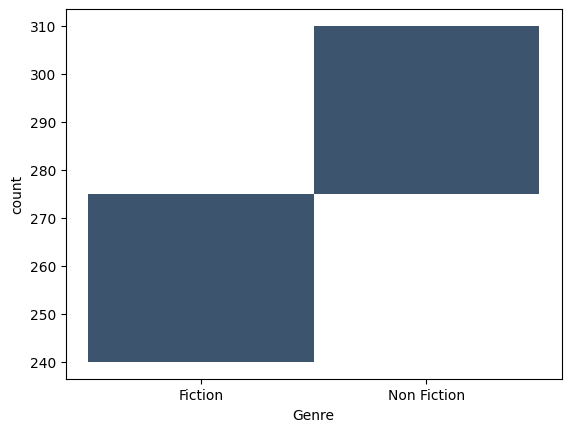

In [164]:
genres = df.groupBy("Genre").count()
genres.show()
genres = genres.toPandas()
sns.histplot(genres, x=genres.Genre, y=genres["count"])